In [2]:
from collections import defaultdict

import git
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

repo_path = r'C:\Users\ml\PycharmProjects\LLM-Dec-Hackathon\tests\test_repo'
repo = git.Repo(repo_path)

authors = set()
files = defaultdict(list)
commits = []


def extract_keywords(message):
    tokens = word_tokenize(message)
    stop_words = set(stopwords.words('english'))
    keywords = [word for word in tokens if word not in stop_words and word.isalpha()]
    return keywords


for commit in repo.iter_commits():
    authors.add(commit.author.name)
    commit_files = list(commit.stats.files.keys())
    for file in commit_files:
        files[file].append(commit.hexsha)
    commit_data = {'commit_id': commit.hexsha, 'author': commit.author.name,
        'date': commit.committed_datetime.isoformat(), 'message': commit.message,
        'keywords': extract_keywords(commit.message), 'files': commit_files}
    commits.append(commit_data)

structured_data = {'authors': list(authors), 'files': dict(files), 'commits': commits}


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ml\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ml\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import networkx as nx

G = nx.DiGraph()

# Adding nodes for authors, files, commits, and keywords
for author in structured_data['authors']:
    G.add_node(author, type='author')

for file, versions in structured_data['files'].items():
    G.add_node(file, type='file')
    for version in versions:
        version_node = f"{file}_{version}"
        G.add_node(version_node, type='file_version')
        G.add_edge(file, version_node, type='version')

for commit in structured_data['commits']:
    G.add_node(commit['commit_id'], type='commit', author=commit['author'], date=commit['date'])
    G.add_edge(commit['author'], commit['commit_id'], type='authored')
    for file in commit['files']:
        file_version_node = f"{file}_{commit['commit_id']}"
        G.add_edge(commit['commit_id'], file_version_node, type='modifies')

# Adding keyword nodes and edges
for commit in structured_data['commits']:
    for keyword in commit['keywords']:
        G.add_node(keyword, type='keyword')
        G.add_edge(commit['commit_id'], keyword, type='mentions')


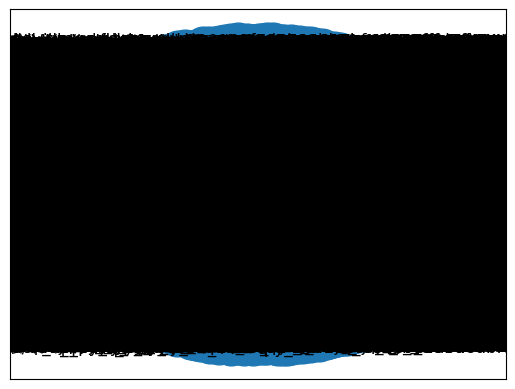

In [4]:
import matplotlib.pyplot as plt

# Basic visualization
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw_networkx_nodes(G, pos, node_size=700)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='black')
nx.draw_networkx_labels(G, pos)
plt.show()
